In [2]:
!pip install open3d

  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 3.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 6.4 MB/s eta 0:00:0000:0100:01m
Using cached retrying-1.3.4-py3-none-any.whl (11 kB)


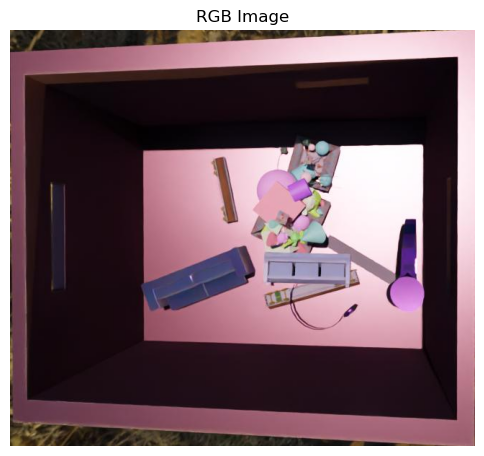

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
import os



# Update path according to your zip content
base_path = "data/911224f8-9915-11ee-9103-bbb8eae05561"

# --- Show RGB image ---
rgb_path = os.path.join(base_path, "rgb.jpg")
img = Image.open(rgb_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("RGB Image")
plt.axis("off")
plt.show()



In [3]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os

# Load data
base_path = "data/8c39418c-9915-11ee-9103-bbb8eae05561"
pc = np.load(os.path.join(base_path, "pc.npy"))       # shape: (3, 578, 646)
masks = np.load(os.path.join(base_path, "mask.npy"))   # shape: (10, 578, 646)
rgb = plt.imread(os.path.join(base_path, "rgb.jpg"))   # optional for color

print("Point cloud shape:", pc.shape)
print("Mask shape:", masks.shape)

# Convert point cloud to shape (578, 646, 3)
pc = np.transpose(pc, (1, 2, 0))  # now (578, 646, 3)

# Visualize each object
for i in range(masks.shape[0]):
    mask = masks[i]  # shape (578, 646)
    points = pc[mask > 0]  # extract 3D points for this instance

    if len(points) == 0:
        continue  # skip empty masks

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Optional: assign color from RGB image
    if rgb is not None:
        rgb_rescaled = rgb[:, :, :3] if rgb.shape[2] == 4 else rgb
        rgb_points = rgb_rescaled[mask > 0] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(rgb_points)

    print(f"Visualizing instance {i} with {len(points)} points")
    o3d.visualization.draw_geometries([pcd], window_name=f"Instance {i}")


Point cloud shape: (3, 343, 550)
Mask shape: (13, 343, 550)
Visualizing instance 0 with 424 points
Visualizing instance 1 with 3619 points
Visualizing instance 2 with 13349 points
Visualizing instance 3 with 3801 points
Visualizing instance 4 with 2637 points
Visualizing instance 5 with 1494 points
Visualizing instance 6 with 1099 points
Visualizing instance 7 with 744 points
Visualizing instance 8 with 9147 points
Visualizing instance 9 with 6051 points
Visualizing instance 10 with 1352 points
Visualizing instance 11 with 5689 points
Visualizing instance 12 with 1629 points


In [4]:
import numpy as np
import open3d as o3d
from PIL import Image
import os

# Load data
base_path = "data/8c39418c-9915-11ee-9103-bbb8eae05561"
pc = np.load(os.path.join(base_path, "pc.npy"))         # (3, 578, 646)
rgb = np.array(Image.open(os.path.join(base_path, "rgb.jpg")))  # (578, 646, 3)

# Transpose pc to (578, 646, 3)
pc = np.transpose(pc, (1, 2, 0))  # shape: (578, 646, 3)

# Flatten both for point cloud
points = pc.reshape(-1, 3)           # shape: (578*646, 3)
colors = rgb.reshape(-1, 3) / 255.0  # normalize RGB, shape: (578*646, 3)

# Remove invalid/depthless points (e.g. z == 0 or NaN)
valid_mask = np.isfinite(points).all(axis=1) & (points[:, 2] != 0)
points = points[valid_mask]
colors = colors[valid_mask]

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize
o3d.visualization.draw_geometries([pcd], window_name="RGB Point Cloud")


In [ ]:
import numpy as np
import open3d as o3d
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load files
base_path = "data/911224f8-9915-11ee-9103-bbb8eae05561"
pc = np.load(os.path.join(base_path, "pc.npy"))        # (3, 578, 646)
masks = np.load(os.path.join(base_path, "mask.npy"))   # (10, 578, 646)
bboxes = np.load(os.path.join(base_path, "bbox3d.npy"))  # (10, 8, 3)
rgb = np.array(Image.open(os.path.join(base_path, "rgb.jpg")))

# Convert pc to shape (578, 646, 3)
pc = np.transpose(pc, (1, 2, 0))  # (578, 646, 3)
H, W, _ = pc.shape

# Prepare colors for each instance
colors_palette = plt.cm.get_cmap('tab10', masks.shape[0])
scene_points = []
scene_colors = []
all_bboxes = []

# Add all points and color by instance
for i in range(masks.shape[0]):
    mask = masks[i]
    instance_points = pc[mask > 0]

    if len(instance_points) == 0:
        continue

    color = colors_palette(i)[:3]
    instance_colors = np.tile(color, (instance_points.shape[0], 1))
    
    scene_points.append(instance_points)
    scene_colors.append(instance_colors)

    # Create bounding box LineSet
    edges = [
        [0,1], [1,2], [2,3], [3,0],  # bottom face
        [4,5], [5,6], [6,7], [7,4],  # top face
        [0,4], [1,5], [2,6], [3,7]   # vertical edges
    ]
    box = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(bboxes[i]),
        lines=o3d.utility.Vector2iVector(edges)
    )
    box.paint_uniform_color(color)
    all_bboxes.append(box)

# Combine all instance points
scene_points = np.concatenate(scene_points, axis=0)
scene_colors = np.concatenate(scene_colors, axis=0)

# Create final point cloud
scene_pcd = o3d.geometry.PointCloud()
scene_pcd.points = o3d.utility.Vector3dVector(scene_points)
scene_pcd.colors = o3d.utility.Vector3dVector(scene_colors)

# Visualize everything together
print(f"Visualizing {masks.shape[0]} instances in a unified point cloud...")
o3d.visualization.draw_geometries([scene_pcd] + all_bboxes, window_name="Scene with All Instances")


/var/folders/hg/s88_m6r92t97048x4qjmjlxr0000gn/T/ipykernel_76090/2995951623.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_palette = plt.cm.get_cmap('tab10', masks.shape[0])


Visualizing 10 instances in a unified point cloud...


: 

In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load files
base_path = "data/911224f8-9915-11ee-9103-bbb8eae05561"

pc = np.load(os.path.join(base_path, "pc.npy"))        # shape: (3, 578, 646)
masks = np.load(os.path.join(base_path, "mask.npy"))   # shape: (10, 578, 646)
bboxes = np.load(os.path.join(base_path, "bbox3d.npy"))  # shape: (10, 8, 3)
rgb = np.array(Image.open(os.path.join(base_path, "rgb.jpg")))  # shape: (578, 646, 3)

# Convert pc to shape (578, 646, 3)
pc = np.transpose(pc, (1, 2, 0))

# Define cuboid edges (for LineSet)
edges = [
    [0,1], [1,2], [2,3], [3,0],  # bottom face
    [4,5], [5,6], [6,7], [7,4],  # top face
    [0,4], [1,5], [2,6], [3,7]   # vertical edges
]

# Loop over instances
for i in range(masks.shape[0]):
    mask = masks[i]  # shape: (578, 646)
    points = pc[mask > 0]

    if len(points) == 0:
        print(f"Skipping empty mask {i}")
        continue

    # Create point cloud for instance
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Optional: color from RGB image
    if rgb.shape[2] == 4: rgb = rgb[:, :, :3]
    colors = rgb[mask > 0] / 255.0
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Bounding box as LineSet
    corners = bboxes[i]  # shape: (8, 3)
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(corners),
        lines=o3d.utility.Vector2iVector(edges)
    )
    line_set.paint_uniform_color([1, 0, 0])  # red

    # Visualize
    print(f"Visualizing instance {i} with {len(points)} points")
    o3d.visualization.draw_geometries([pcd, line_set], window_name=f"Instance {i}")

Visualizing instance 0 with 2435 points
Visualizing instance 1 with 1293 points
Visualizing instance 2 with 7336 points
Visualizing instance 3 with 2315 points
Visualizing instance 4 with 274 points
Visualizing instance 5 with 339 points
Visualizing instance 6 with 5002 points
Visualizing instance 7 with 1537 points
Visualizing instance 8 with 1809 points
Visualizing instance 9 with 3431 points


In [ ]:
!pyhton dataset_pickplace.py